In [191]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, \
  PredefinedSplit
from sklearn.preprocessing import Imputer, LabelEncoder, OneHotEncoder
from collections import defaultdict
from sklearn.feature_selection import SelectKBest, SelectPercentile, chi2, \
  f_classif, f_regression
from sklearn.tree import DecisionTreeClassifier, export_graphviz, \
  DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, \
  roc_curve, r2_score, mean_squared_error, recall_score
from pydotplus import graph_from_dot_data
import graphviz
import gc

In [198]:
java_data= pd.read_excel('C:/Users/HP/Desktop/honors project/cleaned data/51java-xlsx (5).xlsx')

In [199]:
print(java_data.describe(include = 'all'))

       joblocation_num    Internship     education    experience  \
count     10253.000000  10253.000000  10253.000000  10253.000000   
mean          2.057739      0.028479      1.270457      2.766995   
std           0.981780      0.166346      0.521581      1.608307   
min           1.000000      0.000000      0.000000      0.000000   
25%           1.000000      0.000000      1.000000      2.000000   
50%           2.000000      0.000000      1.000000      3.000000   
75%           3.000000      0.000000      2.000000      3.000000   
max           4.000000      1.000000      3.000000      8.000000   

       salary_grade  company_style  company_scale  job_industry  \
count  10253.000000   10253.000000   10253.000000  10253.000000   
mean       0.225105       1.802692       2.848142      5.345460   
std        0.417672       1.517290       1.455832      3.651231   
min        0.000000       1.000000       1.000000      1.000000   
25%        0.000000       1.000000       2.000000   

In [200]:
print(java_data.shape)

(10253, 9)


In [201]:
fig = plt.figure(figsize=(28,21))

<Figure size 2016x1512 with 0 Axes>

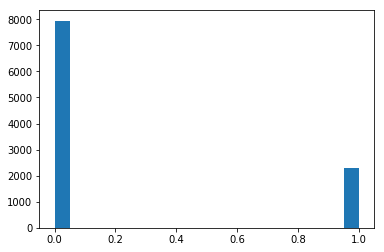

In [202]:
fig = plt.figure()
plt.hist(java_data['salary_grade'],bins=20)
plt.show()


In [203]:
X = java_data.drop('salary_grade',axis=1) 
y = (java_data['salary_grade'] == 1).astype(np.int32)
train_X,test_X,train_y,test_y=train_test_split(X,y,test_size=0.25, random_state = 125)


In [204]:
features=['joblocation_num','Internship','education','experience','company_style','company_scale','job_industry','job_classification']

In [206]:
sp = SelectPercentile(f_classif, 90)
sp.fit(train_X, train_y)
scores=pd.DataFrame({'feature':np.array(features), 'score':sp.scores_})
scores.sort_values("score", ascending = False, inplace=True)
print(scores)


              feature        score
3          experience  1836.602122
0     joblocation_num   778.358154
1          Internship   714.775007
2           education   136.766268
5       company_scale    75.665750
7  job_classification    46.492079
6        job_industry    38.261838
4       company_style    15.721116


In [207]:
train_X = sp.transform(train_X)
test_X = sp.transform(test_X)
print(train_X.shape)
## (2099, 30)
print(test_X.shape)
## (900, 30)

(7689, 7)
(2564, 7)


In [220]:
clf = DecisionTreeClassifier()
param_grid = {'max_depth': [3,4,5], 'min_impurity_decrease': [0.001,0.003]}
gs = GridSearchCV(clf, param_grid, 'roc_auc', cv = 3)
gs.fit(train_X, train_y)
cv_results = pd.DataFrame(gs.cv_results_)
print(gs.best_estimator_)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.001, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


C:\Users\HP\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\utils\deprecatio

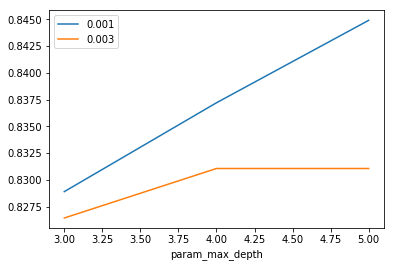

In [221]:
fig, ax = plt.subplots()
grouped = cv_results.groupby('param_min_impurity_decrease')
for key, group in grouped:
    group.plot(ax=ax, x='param_max_depth', y='mean_test_score', label=key)
plt.show()

In [222]:
clf = gs.best_estimator_
clf.fit(train_X, train_y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.001, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

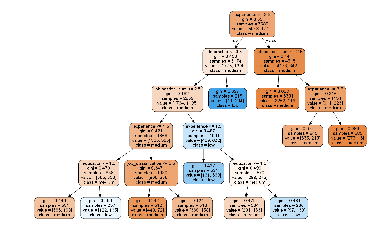

In [223]:
dot_data = export_graphviz(clf, out_file=None, max_depth=5,  
                           feature_names=np.array(features)[sp.get_support()].tolist(), 
                           class_names=['medium','low'],
                           filled=True, rounded=True)
graph = graph_from_dot_data(dot_data)
graph.write_png('tree.png') 
img = plt.imread('tree.png')
fig = plt.figure()
plt.imshow(img)
plt.axis('off')
plt.show()

0.8389235569422777
0.8460945386333467
0.5711318795430944


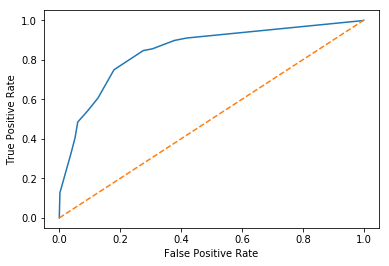

In [216]:
predict_y = clf.predict(test_X)
probas_y = clf.predict_proba(test_X)
print(accuracy_score(test_y, predict_y))
## 0.9
print(roc_auc_score(test_y, probas_y[:, 1]))
## 0.8577739501109058
print(f1_score(test_y, predict_y))
## 0.4642857142857143
fpr, tpr, thresholds = roc_curve(test_y, probas_y[:, 1])
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()